## Loading data

### getting rid of corrupt images

In [1]:
%%capture
import os
import tensorflow as tf

2022-12-09 15:58:25.702124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 15:58:25.979836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 15:58:25.979874: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-09 15:58:26.032871: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-09 15:58:27.375885: W tensorflow/stream_executor/pla

In [2]:
%%capture
!pip3 install PIL

In [3]:
from PIL import Image
import os, pathlib

base_dir = '/work/ddsm'

for subdir, dirs, files in os.walk(base_dir):
    for file in files:
        try:
        
            im = Image.open(os.path.join(subdir, file))
        except:
           print(f"file {file} is corrupted")
           os.remove(os.path.join(subdir, file))

In [4]:
SEED=100
BATCH_SIZE = 20

### path to target directories

In [5]:
# Assign training and validation set directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


### reading and labeling images for training and validation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(128, 128), 
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical'
        )

Found 8729 images belonging to 3 classes.
Found 2483 images belonging to 3 classes.


## Building Neural Network

In [7]:
import tensorflow as tf
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

2022-12-09 15:58:55.493574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-09 15:58:55.493617: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-09 15:58:55.493641: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-75ebf1e2-895a-4159-b805-a6e4c496ea4e): /proc/driver/nvidia/version does not exist
2022-12-09 15:58:55.493979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# from tensorflow.keras.optimizers.experimental import RMSprop
# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

## Training model

### Penalizing model differently for each class (imbalanced data)

In [10]:
class_weight = {0: 5,
                1: 5,
                2: 1}

### Feeding data to the neural network

In [11]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      class_weight=class_weight,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/10
100/100 [==============================] - 46s 444ms/step - loss: 1.9399 - accuracy: 0.6450 - val_loss: 0.8609 - val_accuracy: 0.8620
Epoch 2/10
100/100 [==============================] - 44s 444ms/step - loss: 1.9488 - accuracy: 0.7995 - val_loss: 0.9491 - val_accuracy: 0.8790
Epoch 3/10
100/100 [==============================] - 44s 435ms/step - loss: 1.8915 - accuracy: 0.8079 - val_loss: 0.7927 - val_accuracy: 0.8660
Epoch 4/10
100/100 [==============================] - 45s 446ms/step - loss: 1.9172 - accuracy: 0.8020 - val_loss: 0.8805 - val_accuracy: 0.8830
Epoch 5/10
100/100 [==============================] - 44s 439ms/step - loss: 1.8957 - accuracy: 0.8030 - val_loss: 0.9345 - val_accuracy: 0.8620
Epoch 6/10
100/100 [==============================] - 43s 433ms/step - loss: 1.8861 - accuracy: 0.8045 - val_loss: 0.8921 - val_accuracy: 0.8580
Epoch 7/10
100/100 [==============================] - 43s 434ms/step - loss: 1.8634 - accuracy: 0.8065 - val_loss: 0.9018 - val_ac

## Evaluating model

### Visualizing training history

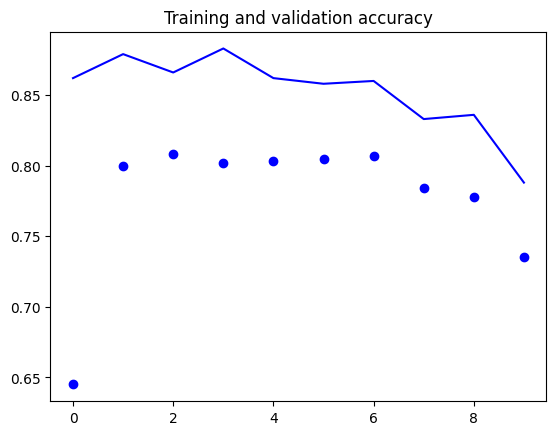

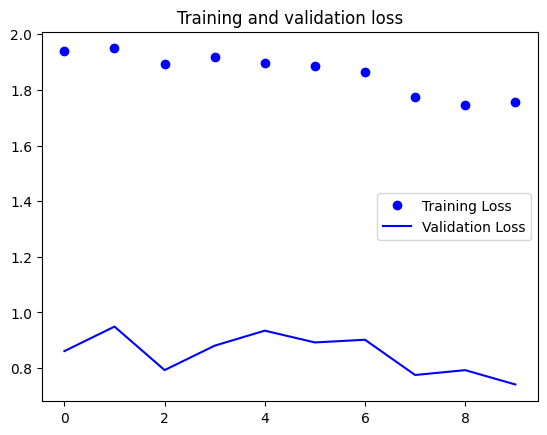

In [12]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_loss_acc(history)

### Visualizing confusion matrix

#### making predictions on validation data

In [13]:
 ypred=model.predict(validation_generator)

125/125 [==============================] - 14s 114ms/step


In [14]:
import numpy as np
for i, y in enumerate (ypred):
    index = np.argmax(y)
    y = np.zeros(3)
    y[index] = 1
    ypred[i] = y

###

#### Extracting labels from BatchDataset object (This was tough XD)

In [15]:
import math
import numpy as np

length = len(validation_generator.filenames)
number_of_generator_calls = math.ceil(length / (1.0 * BATCH_SIZE)) # 1.0 above is to skip integer division
ytrue = np.empty([length, 3])

index=0
print(ytrue.shape)
for i in range(0,int(number_of_generator_calls)):
    for sample in np.array(validation_generator[i][1]):
        ytrue[index] = sample
        index+=1

(2483, 3)


#### Plotting the confusion matrix

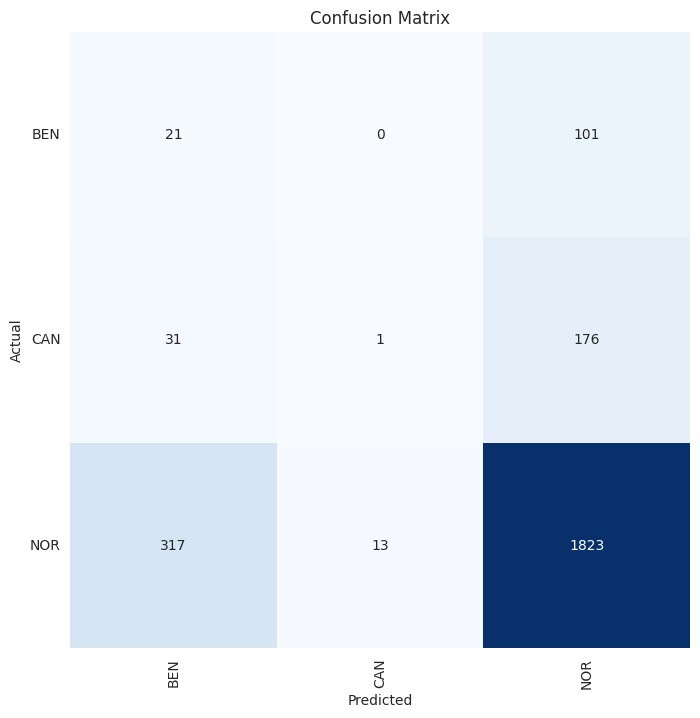

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
classes=['BEN', 'CAN', 'NOR']

if len(classes)<= 30: # if more than 30 classes plot is not useful to cramed
        # create a confusion matrix 
        cm = confusion_matrix(ytrue.argmax(axis=1), ypred.argmax(axis=1))        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

### Printing models accuracy

In [ ]:
from sklearn.metrics import metrics
accuracy_score(ytrue.argmax(axis=1), ypred.argmax(axis=1))

### Printing classification report

In [17]:
clr = classification_report(ytrue.argmax(axis=1), ypred.argmax(axis=1), target_names=classes)
print("Classification Report:\n----------------------\n", clr) 

Classification Report:
----------------------
               precision    recall  f1-score   support

         BEN       0.06      0.17      0.09       122
         CAN       0.07      0.00      0.01       208
         NOR       0.87      0.85      0.86      2153

    accuracy                           0.74      2483
   macro avg       0.33      0.34      0.32      2483
weighted avg       0.76      0.74      0.75      2483



## Making predictions

In [18]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

path = '/work/test_img.png'

img = load_img(path, target_size=(128, 128), color_mode='grayscale')
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
images /= 255.0

classes = model.predict(images)
print(classes)

1/1 [==============================] - 0s 74ms/step
[[0.28270364 0.22762549 0.4896709 ]]


## Saving model

Saving the weights of the NN so we do not have to train the model whenever we are predicting an image

In [19]:
model.save('../model')
!zip -r /content/model.zip /content/model # zipping the model

INFO:tensorflow:Assets written to: ../model/assets
/bin/bash: zip: command not found


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=75ebf1e2-895a-4159-b805-a6e4c496ea4e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>